In [22]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb

import gc

import warnings
warnings.filterwarnings('ignore')


In [23]:
# Load Data

file_name = "./data/train_preprocessed2.csv"
train_df = pd.read_csv(file_name, low_memory = False)

train_df.head()

,A..papers,A.papers,B.papers,C.papers,Dif.countries,Perc_non_australian,Number.people,PHD,Max.years.univ,Grants.succ,...,SEO.11,SEO.12,SEO.13,SEO.14,SEO.15,SEO.16,SEO.17,SEO.18,SEO.19,Grant.Status
0,4.0,2.0,0.0,0.0,1,0.00,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,6.0,12.0,2.0,2.0,1,1.00,1,1.0,20.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,7.0,20.0,20.0,7.0,2,0.75,4,2.0,50.0,0.0,...,0,0,2,0,0,0,0,0,0,1
3,0.0,3.0,13.0,3.0,1,1.00,2,2.0,15.0,0.0,...,0,0,2,0,0,0,0,0,0,1
4,3.0,0.0,1.0,0.0,1,0.00,1,1.0,10.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [24]:
#Setup data : Divide Test and Train set

array = train_df.values

data = array[:, 0:70]
target = array[:, 70]

data, target

seed = 7
test_size = 0.2

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = test_size, random_state = seed)


In [25]:
min_child_weightP = np.zeros(30)
max_depthP = np.zeros(30)
gammaP = np.zeros(30)
subsampleP = np.zeros(30)
colsample_bytreeP = np.zeros(30)
aucP = np.zeros(30)
cnt = 0

In [26]:
# Making a XGB Train Model Function

def XGB_Train_Model_using_KFold(min_child_weight, max_depth, gamma, subsample,  colsample_bytree) : 
    xgb_params = {
        'n_trees' : 250,
        'eta' : 0.2,
        'max_depth' : int(max_depth),
        'subsample' : max(min(subsample, 1), 0),
        'objective' : 'reg:linear', 
        'base_score' : np.mean(target),
        'eval_metric' : 'auc',
        'silent' : 1,
        'min_child_weight' : int(min_child_weight),
        'gamma' : max(gamma, 0), 
        'colsample_bytree' : max(min(colsample_bytree, 1), 0)
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    
    #n_splits = int(max(n_splits_param, 2))
    kfold = KFold(n_splits = 5, random_state = 7)
    results = cross_val_score(model, data, target, cv = kfold)
    accuracy = results.mean()*100
    print("Accuracy : %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    global min_child_weightP 
    global max_depthP 
    global gammaP 
    global subsampleP
    global colsample_bytreeP
    global aucP
    global cnt
    
    min_child_weightP[cnt] = min_child_weight
    max_depthP[cnt] = max_depth
    gammaP[cnt] = gamma
    subsampleP[cnt] = subsample
    colsample_bytreeP[cnt] = colsample_bytree
    aucP[cnt] = accuracy
    cnt += 1
    
    return accuracy

In [27]:
xgb_params = {
    
    #Learning Rate  -> not needed, doesn't change result in range (0.01, 0.2)
    #'eta' : (0.01, 0.2),
    
    #Minimum sum of weights : to control overfitting
    'min_child_weight' : (1, 20), 
    
    #Maximum depth of a tree : to control overfitting
    'max_depth' : (2, 10),
    
    #minimum loss reduction required to make a split : makes algorithm conservative
    'gamma' : (0, 10), 
    
    #max_delta_step is not needed since data is not imbalanced
    #'max_delta_step' : (0, 10),
    
    #Fraction of observations to be randomly samples for each tree
    #Lower: prevent overfitting
    'subsample' : (0.5, 1),
    
    #Fraction of columns to be randomly samples for each tree
    'colsample_bytree' : (0.1, 1),
    
    #colsamble_bylevel is not needed since subsample and colsample_bytree will do the job
    #'colsample_bylevel' = (0.1, 1),
    
    #L2 regularization term on weights
    #'lambda' = (?, ?)
    
    #L1 regularization term on weight
    #'alpha' = (?, ?)
    
    #scale_pos_weight is not needed since data is not imbalanced
    #'scale_pos_weight' = (0, 10)
    #'n_splits_param' : (5, 10)
}


xgb_bayesOPT = BayesianOptimization(XGB_Train_Model_using_KFold, xgb_params)
xgb_bayesOPT.maximize(init_points = 5, n_iter = 25)


Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Accuracy : 84.97% (3.68%)
    1 | 00m08s |   84.96869 |             0.5922 |    1.7163 |      8.8191 |            12.5572 |      0.5822 | 
Accuracy : 82.97% (6.05%)
    2 | 00m02s |   82.97082 |             0.5305 |    3.3886 |      3.3458 |            10.8332 |      0.7020 | 
Accuracy : 83.84% (4.20%)
    3 | 00m06s |   83.84314 |             0.4028 |    3.4933 |      8.9582 |            13.9459 |      0.5184 | 
Accuracy : 84.03% (5.09%)
    4 | 00m09s |   84.02723 |             0.6934 |    3.2696 |      8.0919 |            17.1475 |      0.6340 | 
Accuracy : 82.37% (5.91%)
    5 | 00m05s |   82.37358 |             0.9229 |    5.0709 |      4.2418 |             6.2946 |      0.7146 | 
Bayesian Optimization
-------------------------------------------

In [29]:
min_child_weightP 


array([12.55720059, 10.83323355, 13.94588551, 17.1474561 ,  6.29458218,
       14.3277853 , 10.17531022, 13.52151897, 13.20062466, 13.95171635,
       11.90115762,  8.69252996, 13.01095929, 15.59965071,  9.55965324,
       10.88665391, 13.25646252, 11.06838089,  9.82750428, 10.37663037,
       10.01340321,  8.14087459,  9.69396732,  8.51809346, 11.4540236 ,
        7.40496104, 15.85194765,  9.44152363, 14.41197862, 15.88517107])

In [30]:
max_depthP 


array([8.81905456, 3.34576754, 8.9581834 , 8.09192268, 4.24184443,
       7.80725898, 6.97656408, 7.59532269, 9.05139586, 9.35219521,
       8.63152167, 5.33981907, 9.23056445, 8.51682163, 4.73359065,
       6.48147631, 8.28238897, 7.06512072, 5.45138446, 6.14778397,
       5.38833287, 4.10460322, 5.16389749, 5.7224349 , 7.27055768,
       4.79020253, 8.12666778, 5.28297262, 8.7071504 , 8.02938444])

In [47]:
aucP
aucP = aucP /100

In [46]:
aucP

array([84.96868593, 82.97082387, 83.84314015, 84.02723272, 82.37357814,
       84.1990463 , 84.49772522, 83.98083369, 84.38279596, 84.55498542,
       84.24503647, 83.69387323, 83.63625693, 84.66998723, 82.50000165,
       85.24412577, 84.57790797, 83.95791115, 85.23256558, 84.97989661,
       84.62416851, 84.00402002, 83.92338884, 84.58963962, 84.66992128,
       83.24634944, 85.47375349, 85.08329206, 84.84211734, 83.28089153])

In [ ]:
'''
'min_child_weight' : (1, 20), 
'max_depth' : (2, 10),
'gamma' : (0, 10), 
'subsample' : (0.5, 1),
'colsample_bytree' : (0.1, 1),
    
''' 


In [48]:
min_child_weightP = (min_child_weightP - 1) / 20
max_depthP = (max_depthP - 2) / 8
gammaP = gammaP / 10
subsampleP = (subsampleP - 0.5) / 0.5
colsample_bytreeP = (colsample_bytreeP - 0.1) / 0.9

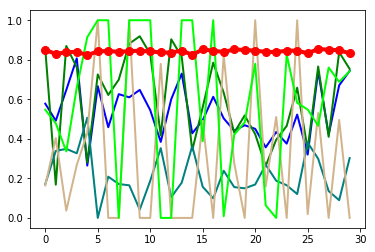

In [49]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'step' : np.arange(30), 'min_child_weight' : min_child_weightP, 'max_depth' : max_depthP, 'gamma' : gammaP, 'subsample' : subsampleP, 'colsample_bytree' : colsample_bytreeP, 'auc' : aucP})
plt.plot( 'step', 'min_child_weight', data=df, marker='', color='blue', linewidth=2)
plt.plot( 'step', 'max_depth', data = df, marker = '', color = 'green', linewidth = 2)
plt.plot( 'step', 'gamma', data = df, marker = '', color = 'teal', linewidth = 2)
plt.plot( 'step', 'subsample', data = df, marker = '', color = 'tan', linewidth = 2)
plt.plot( 'step', 'colsample_bytree', data = df, marker = '', color = 'lime', linewidth = 2)
plt.plot( 'step', 'auc', data = df, marker = 'o', color = 'red', markersize = 8, linewidth = 4)
